# Shape functions

Also known as basis functions, interpolation polynomials and so on. Typically unknown field variable is interpolated from element nodal values using continuous functions. That is, 

Standard Lagrange polynomials as supported.

Linear shape functions:
- Seg2
- Tri3
- Quad4
- Tet4
- Pyr5
- Wedge6
- Hex8

Quadratic and biquadratic shape functions:
- Seg3
- Tri6, Tri7
- Quad8, Quad9
- Tet10
- Wedge15
- Hex20, Hex27

NURBS shape functions:
- NSeg
- NSurf
- NSolid

Evaluating basis and derivative of basis functions with respect to dimensionless coordinates:

In [2]:
using FEMBase
using FEMBase.FEMBasis: eval_dbasis!, jacobian, grad, interpolate,
                        get_reference_element_coordinates, create_basis
B = Quad4()

FEMBasis.Quad4()

In [3]:
length(B)

4

In [4]:
size(B)

(2, 4)

For fast evaluations, one must allocate array outside of the hot loops to get speed.

In [5]:
N = zeros(1, 4)
dN = zeros(2, 4)
xi = (0.0, 0.0)

(0.0, 0.0)

In [6]:
eval_basis!(B, N, xi)

1×4 Array{Float64,2}:
 0.25  0.25  0.25  0.25

In [7]:
eval_dbasis!(B, dN, xi)

2×4 Array{Float64,2}:
 -0.25   0.25  0.25  -0.25
 -0.25  -0.25  0.25   0.25

For Langrange interpolation polynomials, by definition, on each node shape function corresponding to that node gets value of 1 and the rest is zero. Node ordering follows the same defined in e.g. in ABAQUS and in many other FEM softwares.

In [8]:
get_reference_element_coordinates(Quad4)

((-1.0, -1.0), (1.0, -1.0), (1.0, 1.0), (-1.0, 1.0))

In [9]:
for xi in get_reference_element_coordinates(Quad4)
    eval_basis!(B, N, xi)
    println("$N at $xi")
end

[1.0 0.0 0.0 0.0] at (-1.0, -1.0)
[0.0 1.0 0.0 0.0] at (1.0, -1.0)
[0.0 0.0 1.0 0.0] at (1.0, 1.0)
[0.0 0.0 0.0 1.0] at (-1.0, 1.0)


## Mathematics

Without knowing anything about the real shape of domain, `eval_dbasis!` is calculating gradient with respect to dimensionless coordinates $\xi_i$, i.e.

\begin{equation}
\frac{\partial\boldsymbol{N}}{\partial\boldsymbol{\xi}}=\left[\begin{array}{cccc}
\frac{\partial N_{1}}{\partial\xi_{1}} & \frac{\partial N_{2}}{\partial\xi_{1}} & \cdots & \frac{\partial N_{n}}{\partial\xi_{1}}\\
\frac{\partial N_{1}}{\partial\xi_{2}} & \frac{\partial N_{2}}{\partial\xi_{2}} & \cdots & \frac{\partial N_{n}}{\partial\xi_{2}}\\
\frac{\partial N_{1}}{\partial\xi_{3}} & \frac{\partial N_{2}}{\partial\xi_{3}} & \cdots & \frac{\partial N_{n}}{\partial\xi_{3}}
\end{array}\right]
\end{equation}

Usually this is not wanted, but instead gradient of basis functions is calculated with respect to natural coordinates $X_i$,

\begin{equation}
\frac{\partial\boldsymbol{N}}{\partial\boldsymbol{X}}=\left[\begin{array}{cccc}
\frac{\partial N_{1}}{\partial X_{1}} & \frac{\partial N_{2}}{\partial X_{1}} & \cdots & \frac{\partial N_{n}}{\partial X_{1}}\\
\frac{\partial N_{1}}{\partial X_{2}} & \frac{\partial N_{2}}{\partial X_{2}} & \cdots & \frac{\partial N_{n}}{\partial X_{2}}\\
\frac{\partial N_{1}}{\partial X_{3}} & \frac{\partial N_{2}}{\partial X_{3}} & \cdots & \frac{\partial N_{n}}{\partial X_{3}}
\end{array}\right]
\end{equation}

To get this, inverse of Jacobian matrix is needed.

In [10]:
X = ([0.0, 0.0], [1.0, 0.0], [1.0, 1.0], [0.0, 1.0])
xi = (0.0, 0.0)
J = jacobian(B, X, xi)

2×2 Array{Float64,2}:
 0.5  0.0
 0.0  0.5

In [11]:
inv(J) * dN

2×4 Array{Float64,2}:
 -0.5   0.5  0.5  -0.5
 -0.5  -0.5  0.5   0.5

Or directly:

In [12]:
dNdX = grad(B, X, xi)

2×4 Array{Float64,2}:
 -0.5   0.5  0.5  -0.5
 -0.5  -0.5  0.5   0.5

If interpolation domain is manifold, Jacobian is not square and inverse cannot be taken.

In [13]:
X2 = ([0.0,0.0,0.0], [1.0, 0.0,1.0], [1.0,1.0,1.0], [0.0,1.0,0.0])
xi = (0.0, 0.0)
J = jacobian(B, X2, xi)

2×3 Array{Float64,2}:
 0.5  0.0  0.5
 0.0  0.5  0.0

One can use Jacobian to calculate [surface integral](https://en.wikipedia.org/wiki/Surface_integral):

\begin{equation}
\iint_{S}f\,\mathrm{d}\Sigma=\iint_{T}f\left(\boldsymbol{x}\left(s,t\right)\right)\left\Vert \frac{\partial\boldsymbol{x}}{\partial s}\times\frac{\partial\boldsymbol{x}}{\partial t}\right\Vert \,\mathrm{d}s\mathrm{d}t
\end{equation}

In [14]:
4*norm(cross(J[1,:], J[2,:])), sqrt(2) # area of manifold

(1.4142135623730951, 1.4142135623730951)

Gradient of e.g. displacement field or temperature field can be also evaluated:

In [15]:
u = ([0.0, 0.0], [1.0, -1.0], [2.0, 3.0], [0.0, 0.0])
T = (1.0, 2.0, 3.0, 4.0)
grad(B, u, X, xi)

2×2 Array{Float64,2}:
 1.5  0.5
 1.0  2.0

In [16]:
grad(B, T, X, xi)

1×2 RowVector{Float64,Array{Float64,1}}:
 0.0  2.0

One can interpolate fields using basis:

In [17]:
interpolate(B, u, xi)

2-element Array{Float64,1}:
 0.75
 0.5 

In [18]:
interpolate(B, T, xi)

2.5

At last to avoid unnecessary memory allocations, a struct `BasisInfo` is introduced, containing memory space for calculations.

In [19]:
bi = BasisInfo(Quad4)
eval_basis!(bi, X, xi)

FEMBasis.BasisInfo{FEMBasis.Quad4,Float64}([0.25 0.25 0.25 0.25], [-0.25 0.25 0.25 -0.25; -0.25 -0.25 0.25 0.25], [-0.5 0.5 0.5 -0.5; -0.5 -0.5 0.5 0.5], [0.5 0.0; 0.0 0.5], [2.0 -0.0; -0.0 2.0], 0.25)

In [20]:
bi.J

2×2 Array{Float64,2}:
 0.5  0.0
 0.0  0.5

In [21]:
bi.N

1×4 Array{Float64,2}:
 0.25  0.25  0.25  0.25

In [22]:
bi.dN

2×4 Array{Float64,2}:
 -0.25   0.25  0.25  -0.25
 -0.25  -0.25  0.25   0.25

In [23]:
bi.detJ

0.25

In [24]:
bi.grad

2×4 Array{Float64,2}:
 -0.5   0.5  0.5  -0.5
 -0.5  -0.5  0.5   0.5

In [25]:
bi.invJ

2×2 Array{Float64,2}:
  2.0  -0.0
 -0.0   2.0

In [26]:
gradu = zeros(2, 2)
grad!(bi, gradu, u)

2×2 Array{Float64,2}:
 1.5  0.5
 1.0  2.0

## Defining custom shape functions

Depending from the type of shape functions, they can be created more or less automatic way. For Lagrange type interpolation, ones needs only to define polynomial and corner points for domain. For example, if domain is $[0,1]^2$, one can use `create_basis`:

In [27]:
code = create_basis(
    :MyQuad,
    "My special domain",
    (
        (0.0, 0.0),
        (1.0, 0.0),
        (1.0, 1.0),
        (0.0, 1.0),
    ),
    "1 + u + v + u*v"
)
eval(code)

In [28]:
B = MyQuad()
xi = (0.5, 0.5)
eval_basis!(B, N, xi)

1×4 Array{Float64,2}:
 0.25  0.25  0.25  0.25

In this case partial derivatives of shape functions are with respect to $X$, because interpolation polynomials are calculated against real domain and not "reference domain":

In [29]:
eval_dbasis!(B, dN, xi)

2×4 Array{Float64,2}:
 -0.5   0.5  0.5  -0.5
 -0.5  -0.5  0.5   0.5

In [30]:
J = jacobian(B, X, xi)

2×2 Array{Float64,2}:
 1.0  0.0
 0.0  1.0

In [31]:
u = ([0.0, 0.0], [1.0, -1.0], [2.0, 3.0], [0.0, 0.0])
grad(B, u, X, xi)

2×2 Array{Float64,2}:
 1.5  0.5
 1.0  2.0

Shape functions can be defined manually and calculate partial derivatives automatically. C1-continuous Hermite shape functions can be defined as:

In [32]:
code = create_basis(
    :C1Hermite,
    "C1-continuous Hermite shape functions",
    (
        (0.0,),
        (0.0,),
        (1.0,),
        (1.0,)
    ),
    (
        "2*u^3 - 3*u^2 + 1",
        "u^3 - 2*u^2 + u",
        "-2*u^3 + 3*u^2",
        "u^3 - u^2"
    )
)
eval(code)

In [33]:
B = C1Hermite()
xi = (0.0,)
eval_basis!(B, N, xi)

1×4 Array{Float64,2}:
 1.0  0.0  0.0  0.0

In [34]:
dN = zeros(1, 4)
eval_dbasis!(B, dN, xi)

1×4 Array{Float64,2}:
 0.0  1.0  0.0  0.0

In [35]:
xi = (1.0,)
eval_basis!(B, N, xi)

1×4 Array{Float64,2}:
 0.0  0.0  1.0  0.0

In [36]:
eval_dbasis!(B, dN, xi)

1×4 Array{Float64,2}:
 0.0  0.0  0.0  1.0

The last option is to build everything from scratch. For that, one must import and define following functions:
- Base.size
- Base.length
- FEMBase.FEMBasis.get_reference_element_coordinates
- FEMBase.FEMBasis.eval_basis!
- FEMBase.FEMBasis.eval_dbasis!

A simple implementation of P-hierarchical 1d-basis would then be

In [37]:
import Base: size, length
import FEMBase: get_reference_element_coordinates,
                eval_basis!, eval_dbasis!,
                AbstractBasis

type PSeg <: AbstractBasis
    order :: Int
end

function PSeg()
    return PSeg(1)
end

function length(basis::PSeg)
    return basis.order+1
end

function size(basis::PSeg)
    return (1, basis.order+1)
end

function get_reference_element_coordinates(basis::PSeg)
    return ((-1.0,), (1.0,))
end

"""
    get_legendre_polynomial(n)

Return Legendgre polynomial of order `n` to inverval ξ ∈ [1, 1].

Implementation uses Bonnet's recursion formula. See
https://en.wikipedia.org/wiki/Legendre_polynomials
"""
function get_legendre_polynomial(n)
    n == 0 && return xi -> 1.0
    n == 1 && return xi -> xi
    Pm1 = get_legendre_polynomial(n-1)
    Pm2 = get_legendre_polynomial(n-2)
    A(xi) = (2.0*n-1.0)*xi*Pm1(xi)
    B(xi) = (n-1.0)*Pm2(xi)
    return xi -> (A(xi)-B(xi))/n
end

"""
    get_legendre_polynomial_derivative(n)

Return derivative of Legendgre polynomial of order `n` to
inverval ξ ∈  [-1, 1]
"""
function get_legendre_polynomial_derivative(n)
    n == 0 && return xi -> 0.0
    n == 1 && return xi -> 1.0
    Pm1 = get_legendre_polynomial_derivative(n-1)
    Pm2 = get_legendre_polynomial_derivative(n-2)
    A(xi) = (2.0*(n-1.0)+1.0)*xi*Pm1(xi)
    B(xi) = (n+1.0-1.0)*Pm2(xi)
    return xi -> (A(xi)-B(xi))/(n-1.0)
end

function eval_basis!{T}(basis::PSeg, N::Matrix{T}, xi::Tuple{T})
    n = length(basis)
    t = xi[1]
    N[1] = 0.5*(1-t)
    N[2] = 0.5*(1+t)
    n < 3 && return N
    for i=3:n
        j = i-1
        P1 = get_legendre_polynomial(j)
        P2 = get_legendre_polynomial(j-2)
        N[i] = 1.0/sqrt(2.0*(2.0*j-1.0))*(P1(t)-P2(t))
    end
    return N
end

function eval_dbasis!{T}(basis::PSeg, dN::Matrix{T}, xi::Tuple{T})
    n = length(basis)
    t = xi[1]
    dN[1] = -0.5
    dN[2] = 0.5
    n < 3 && return N
    for i=3:n
        j = i-1
        P1 = get_legendre_polynomial_derivative(j)
        P2 = get_legendre_polynomial_derivative(j-2)
        dN[i] = 1.0/sqrt(2.0*(2.0*j-1.0))*(P1(t)-P2(t))
    end
    return dN
end

eval_dbasis! (generic function with 21 methods)

In [38]:
B = PSeg()

PSeg(1)

In [39]:
N = zeros(1, 2)
eval_basis!(B, N, (0.0,))

1×2 Array{Float64,2}:
 0.5  0.5

In [40]:
N = zeros(1, 3)
B.order = 2
eval_basis!(B, N, (0.0,))

1×3 Array{Float64,2}:
 0.5  0.5  -0.612372

In [41]:
using PyPlot
B.order = 6
N = zeros(1, length(B))
n = 50
xi = linspace(-1, 1, n)
NN = zeros(n, length(B))
for i=1:n
    eval_basis!(B, N, (xi[i],))
    NN[i,:] = N[:]
end

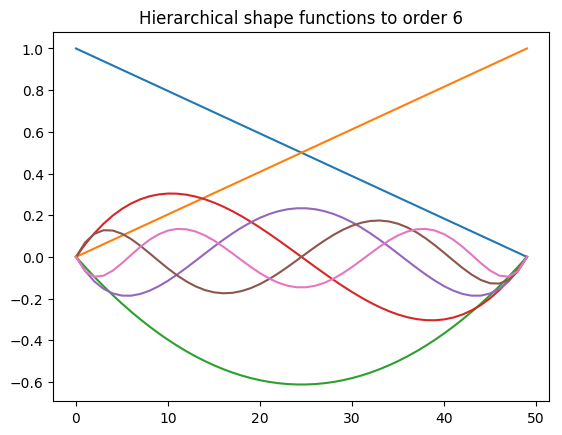

In [42]:
plot(NN)
title("Hierarchical shape functions to order 6");